# Import Modules

In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from tqdm import tqdm
from nltk.corpus import stopwords
import pickle
import os
from langdetect import detect # slow detecting language

import multiprocessing as mp
import numpy as np
import time
print('CPU numbers:',mp.cpu_count())
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
#     print(kwargs)
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
#apply_by_multiprocessing(fullset['Text'], processText, workers=cores)

from nltk.corpus import wordnet
def lemmaWord(word):
    lemma = wordnet.morphy(word)
    if lemma is not None:
        return lemma
    else:
        return word
# def processText(text,lemma=False, gram=1):
#     text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', text, flags=re.MULTILINE) #delete URL, # , and @xxx
#     tokens = word_tokenize(text)
#     whitelist = ["n't", "not", "no"]
#     tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if (i.lower() not in stopwordEn or i.lower() in whitelist) and i.isalpha()]
#     if gram<=1:
#         return tokens
#     else:
#         return [i for i in nltk.ngrams(tokens, gram)]
# New Filter    
def sub_ent(i,length):
    p = float(i/length) #频率作为概率
    logp = np.log2(p)
    return -1 * p * logp
def calc_ent(x):
    if x is not None:
        x_dict = pd.Series(x).value_counts()
        return x_dict.apply(sub_ent, length=len(x)).sum()

stopwordEn = stopwords.words('english')
stopwordEn.extend(['amp'])
whitelist = ["n't", "not", "no"]
# deprecated old version
# def prepareText(i,lemma=False, gram=1):
#     i = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', i, flags=re.MULTILINE) #delete URL, # , and @xxx
#     if len(i) > 5: # delete tweet contains less than 5 characters
#         samples = int(len(i)* 0.2)                                 # sampling 20% characters
#         random5 = np.random.choice(len(i)-1,replace=False, size=samples if samples > 5 or len(i) else 5) # at least 5 samples
#         # if less than 50% sampled character is not English charater, delete the tweets 
#         if sum([1 if (i[s] >= u'\u0041' and i[s] <= u'\u005a') or (i[s] >= u'\u0061' and i[s] <= u'\u007a') or i[s].isdigit() or i[s].isspace() else 0 for s in random5]) > samples/2 :
# #             if detect(i)=='en': #slow but accuracte language detect
#                 tokens = word_tokenize(i)
#                 tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if (i.lower() not in stopwordEn or i.lower() in whitelist) and i.isalpha()]
#                 if gram>1: tokens = [i for i in nltk.ngrams(tokens, gram)]
#                 if len(tokens) > 3: # 2.0 text entropy for 4 different words
#                     entropy = calc_ent(tokens)
#                     if entropy > 2:
#                         return tokens #, entropy

CPU numbers: 32


In [16]:
#使用MP直接从df提取，直接创建2g wc图
# dates = [23,24,25,26,27,28,29]
# for d in dates:
#     with open('df_03{}_news.pickle'.format(d), 'rb') as handle:
#         df = pickle.load(handle)
#     all_words = []
    
#     for i in apply_by_multiprocessing(df['text'], processText, workers=32):
#         all_words.extend(i)
        
#     words_dict = nltk.FreqDist(all_words)
#     with open('./data_0323_29/all_words_{}.pickle'.format(d), 'wb') as handle:
#         pickle.dump(all_words, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     with open('./data_0323_29/words_dict_{}.pickle'.format(d), 'wb') as handle:
#         pickle.dump(words_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
#     print("{} Mar data length:{}, all words count:{}, word dict length:{}".format(d,len(df),len(all_words),len(words_dict)))
    
#     wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=2000, background_color="white").generate_from_frequencies(words_dict)
#     wordcloud.to_file('./data_0323_29/03{}.png'.format(d))
    
#     wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=2000, background_color="white").generate(' '.join(all_words))
#     wordcloud.to_file('./data_0323_29/03{}_2g.png'.format(d))
#     with open('./data_0323_29/words_dict_2G_03{}.pickle'.format(d),'wb') as handle:
#         pickle.dump(wordcloud.words_, handle)        

In [3]:
# 小写先前all_words数据，直接生成字典，再创建图
dates = [23,24,25,26,27,28,29]
TOP_COMMON_2G = 5000
for d in tqdm(dates):
    with open('./data_0323_29/news_all_words_03{}.pickle'.format(d), 'rb') as handle:
        all_words = pickle.load(handle)
    all_words = [i.lower() for i in all_words]
    words_dict = nltk.FreqDist(all_words)
    words_dict_2g_tuple = nltk.FreqDist(nltk.ngrams(all_words, 2))
    words_dict_2g =  nltk.FreqDist()
    for k,v in words_dict_2g_tuple.most_common(TOP_COMMON_2G):
        words_dict_2g[' '.join(k)] = v
    print("{} Mar@ all words count:{}, word dict length:{}, word 2g dict length:{}".format(d,len(all_words),len(words_dict),len(words_dict_2g_tuple)))
    del(all_words)
    with open('./data_032329_new/words_dict_03{}.pickle'.format(d), 'wb') as handle:
        pickle.dump(words_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('./data_032329_new/words_dict_2g_03{}.pickle'.format(d), 'wb') as handle:
        pickle.dump(words_dict_2g, handle, protocol=pickle.HIGHEST_PROTOCOL)
    wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=2000, background_color="white").generate_from_frequencies(words_dict)
    wordcloud.to_file('./data_032329_new/03{}.png'.format(d))
    wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=2000, background_color="white").generate_from_frequencies(words_dict_2g)
    wordcloud.to_file('./data_032329_new/03{}_2g.png'.format(d))

23 Mar@ all words count:33856945, word dict length:264150, word 2g dict length:5000
24 Mar@ all words count:36777573, word dict length:278018, word 2g dict length:5000
25 Mar@ all words count:38490079, word dict length:279959, word 2g dict length:5000
26 Mar@ all words count:37681729, word dict length:284943, word 2g dict length:5000
27 Mar@ all words count:35276626, word dict length:282825, word 2g dict length:5000
28 Mar@ all words count:21789286, word dict length:212762, word 2g dict length:5000
29 Mar@ all words count:13412168, word dict length:162712, word 2g dict length:5000


In [3]:
# 从df数据开始,使用unique news，直接生成字典，再创建图 
dates = [23,24,25,26,27,28,29]
TOP_COMMON_2G = 5000
for d in tqdm(dates):
    with open('df_03{}_news.pickle'.format(d), 'rb') as handle:
        df = pickle.load(handle)
    all_words = []
    for i in apply_by_multiprocessing(pd.Series(df['text'].unique()), processText, workers=32):
        all_words.extend(i)
    words_dict = nltk.FreqDist(all_words)
    words_dict_2g_tuple = nltk.FreqDist(nltk.ngrams(all_words, 2))
    words_dict_2g =  nltk.FreqDist()
    for k,v in words_dict_2g_tuple.most_common(TOP_COMMON_2G):
        words_dict_2g[' '.join(k)] = v
    print("{} Mar@ all words count:{}, word dict length:{}, word 2g dict length:{}".format(d,len(all_words),len(words_dict),len(words_dict_2g_tuple)))
    del(all_words)
    with open('./data_032329_unique/words_dict_03{}.pickle'.format(d), 'wb') as handle:
        pickle.dump(words_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('./data_032329_unique/words_dict_2g_03{}.pickle'.format(d), 'wb') as handle:
        pickle.dump(words_dict_2g, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/7 [00:00<?, ?it/s]

23 Mar@ all words count:30068890, word dict length:264131, word 2g dict length:6921792


 14%|█▍        | 1/7 [03:21<20:08, 201.42s/it]

24 Mar@ all words count:32873300, word dict length:278009, word 2g dict length:7444859


 29%|██▊       | 2/7 [07:05<17:21, 208.21s/it]

25 Mar@ all words count:34053091, word dict length:279950, word 2g dict length:7832270


 43%|████▎     | 3/7 [10:45<14:07, 211.84s/it]

26 Mar@ all words count:33579034, word dict length:284929, word 2g dict length:7910980


 57%|█████▋    | 4/7 [14:16<10:34, 211.40s/it]

27 Mar@ all words count:31489693, word dict length:282809, word 2g dict length:7546628


 71%|███████▏  | 5/7 [17:31<06:53, 206.68s/it]

28 Mar@ all words count:19590224, word dict length:212742, word 2g dict length:5049507


 86%|████████▌ | 6/7 [19:36<03:02, 182.16s/it]

29 Mar@ all words count:12063547, word dict length:162708, word 2g dict length:3522504


100%|██████████| 7/7 [20:54<00:00, 179.20s/it]


In [48]:
# 从df数据开始,使用unique news，直接生成字典，再创建图, 去除stopwords, 使用lemma
dates = [23,24,25,26,27,28,29]
TOP_COMMON_2G = 5000
for d in tqdm(dates):
    with open('df_03{}_news.pickle'.format(d), 'rb') as handle:
        df = pickle.load(handle)
    all_words = []
    for i in apply_by_multiprocessing(pd.Series(df['text'].unique()), processText, workers=32, lemma=True):
        all_words.extend(i)
    words_dict = nltk.FreqDist(all_words)
    words_dict_2g_tuple = nltk.FreqDist(nltk.ngrams(all_words, 2))
    words_dict_2g =  nltk.FreqDist()
    for k,v in words_dict_2g_tuple.most_common(TOP_COMMON_2G):
        words_dict_2g[' '.join(k)] = v
    print("{} Mar@ all words count:{}, word dict length:{}, word 2g dict length:{}".format(d,len(all_words),len(words_dict),len(words_dict_2g_tuple)))
    del(all_words)
    with open('./data_032329_unique/words_dict_03{}_lemma.pickle'.format(d), 'wb') as handle:
        pickle.dump(words_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('./data_032329_unique/words_dict_2g_03{}_lemma.pickle'.format(d), 'wb') as handle:
        pickle.dump(words_dict_2g, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/7 [00:00<?, ?it/s]

23 Mar@ all words count:28318896, word dict length:242521, word 2g dict length:5859012


 14%|█▍        | 1/7 [02:27<14:47, 147.92s/it]

24 Mar@ all words count:30944697, word dict length:255948, word 2g dict length:6279475


 29%|██▊       | 2/7 [05:09<12:40, 152.03s/it]

25 Mar@ all words count:32031190, word dict length:257481, word 2g dict length:6595441


 43%|████▎     | 3/7 [07:57<10:27, 156.81s/it]

26 Mar@ all words count:31617380, word dict length:262402, word 2g dict length:6666166


 57%|█████▋    | 4/7 [10:42<07:58, 159.39s/it]

27 Mar@ all words count:29630899, word dict length:260485, word 2g dict length:6375924


 71%|███████▏  | 5/7 [13:19<05:16, 158.40s/it]

28 Mar@ all words count:18399016, word dict length:192861, word 2g dict length:4339955


 86%|████████▌ | 6/7 [14:59<02:20, 140.99s/it]

29 Mar@ all words count:11314617, word dict length:145074, word 2g dict length:3067302


100%|██████████| 7/7 [16:01<00:00, 137.42s/it]


# New filter

In [427]:
def prepareNews(i,lemma=False, gram=1):
    i = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', i, flags=re.MULTILINE) #delete URL, # , and @xxx
    if len(i) > 50: # delete tweet contains less than 5 characters
        samples = int(len(i)* 0.01)                   # sampling 1% characters
#         size = int(len(i)* 0.01) if len(i)>1000 else 10
        random_c = np.random.choice(len(i),replace=False, size=samples if samples > 5 else 5)
        # if less than 50% sampled character is not English charater, delete the tweets 
        if sum([1 if (i[s] >= u'\u0041' and i[s] <= u'\u005a') or (i[s] >= u'\u0061' and i[s] <= u'\u007a') or i[s].isdigit() or i[s].isspace() else 0 for s in random_c]) > len(random_c)/2 :
#             if detect(i)=='en': #slow but accuracte language detect

                tokens = word_tokenize(i)
                tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if (i.lower() not in stopwordEn or i.lower() in whitelist) and i.isalpha()]
                if gram>1: tokens = [i for i in nltk.ngrams(tokens, gram)]
                if len(tokens) > 10: # equals to 3.3 entropy
                    entropy = calc_ent(tokens)
                    if entropy > 5:
                        return tokens #, entropy

In [378]:
pd.Series([calc_ent(word_tokenize(i)) for i in df.text[:1000]]).describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


count    1000.000000
mean        6.804233
std         1.091333
min         0.000000
25%         6.378448
50%         7.116779
75%         7.558226
max         8.684250
dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


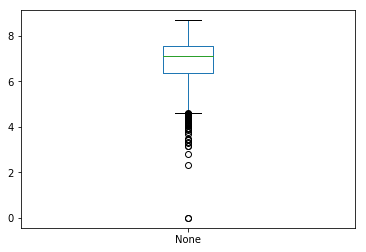

In [379]:
pd.Series([calc_ent(word_tokenize(i)) for i in df.text[:1000]]).plot.box()

In [387]:
pd.Series([len(i) for i in df.text[:1000]]).describe()

count     1000.00000
mean      2609.31400
std       2365.92678
min          1.00000
25%        921.75000
50%       2030.00000
75%       3685.50000
max      25811.00000
dtype: float64

In [345]:
delnews

['विज्ञापन Home › Himachal Pradesh › coronavirus: all industries except pharma and food processing will remain closed {"_id":"5e788a218ebc3e72b32cf02e","slug":"coronavirus-all-industries-except-pharma-and-food-processing-will-remain-closed","type":"story","status": "\\u0938\\u0940\\u0906\\u0908\\u0906\\u0908 \\u091a\\u0947\\u092f\\u0930\\u092e\\u0948\\u0928 \\u092c\\u094b\\u0932\\u0947- \\u092b\\u093e\\u0930\\u094d\\u092e\\u093e \\u0914\\u0930 \\u0916\\u093e\\u0926\\u094d\\u092f \\u092a\\u094d\\u0930\\u0938\\u0902\\u0938\\u094d\\u0915\\u0930\\u0923 \\u0915\\u0947 \\u0905\\u0932\\u093e\\u0935\\u093e \\u0938\\u092d\\u0940 \\u0909\\u0926\\u094d\\u092f\\u094b\\u0917 \\u0930\\u0939\\u0947\\u0902\\u0917\\u0947 \\u092c\\u0902\\u0926","category":{"title":"City & states","title_hn":"\\u0936\\u0939\\u0930 \\u0914\\u0930 \\u0930\\u093e\\u091c\\u094d\\u092f","slug":"city-and-states"}} सीआईआई चेयरमैन बोले- फार्मा और खाद्य प्रसंस्करण के अलावा सभी उद्योग रहेंगे बंद अमर उजाला नेटवर्क, नालागढ़ (सोलन) U

In [238]:
[1 if (i[s] >= u'\u0041' and i[s] <= u'\u005a') or (i[s] >= u'\u0061' and i[s] <= u'\u007a') or i[s].isdigit() or i[s].isspace() else 0 for s in random_c]

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

In [202]:
i = df.text[2]
i = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', i, flags=re.MULTILINE) #delete URL, # , and @xxx
i

'Boeing is suspending its dividend and taking other financial steps to help it weather the commercial aviation slump caused by the coronavirus disease (Covid-19), the US aerospace manufacturer announced late on 20 March.\nBoeing will stop paying its quarterly cash dividend of USD2.055 per share “until further notice”, the company said. In addition, Boeing’s nearly year-old suspension of stock buybacks will continue indefinitely, and CEO Dave Calhoun and Board Chairman Larry Kellner “will forgo all pay until the end of the year”.\n“Boeing is drawing on all of its resources to sustain operations, support its workforce and customers, and maintain supply chain continuity through the Covid-19 crisis and for the long term,” the company said.\n Jane’s (140 of 417 words)'

In [48]:
[i for i in df.text if len(i)<=50]

[' ',
 'Tell AOC cowfarts are the vaccine for covid 19',
 'Read Full Story ... Related articles:',
 'It\'s "China-virus", not coronavirus.',
 ' 7603743 ',
 'Do they want him with or without the corona virus?',
 'COVID-19 Letter From Mayor Coleman ',
 ' Click to Subscribe Older Stories',
 ' 7:25 ',
 ' 7603742 ',
 ' 7603741 ',
 ' 7603739 ',
 ' 7603740 ',
 ' 7603735 ',
 'CORONAVIRUS: Boca, Delray Cases Jump ',
 ' 7603729 ',
 'The cartels getting into the Covid-19 game.',
 'Mercedes-Benz Si (',
 'Joe could sniff for Coronavirus in women’s hair?',
 'Le 13 mars 2020 à 2:05 ',
 'Coronavirus 1 Voters of Utah 0',
 'Le 16 mars 2020 à 2:10 ',
 '1k on Coronavirus FTW.',
 'Le 15 mars 2020 à 2:56 ',
 ' 4 4 ',
 'Le 18 mars 2020 à 2:38 ',
 'é€TTC/min) E-mail :',
 'Le 13 mars 2020 à 2:23 ',
 'Le 18 mars 2020 à 2:55 ',
 'Le 14 mars 2020 à 2:04 ',
 ' 7603724 ',
 ' 7603728 ',
 ' 7603720 ',
 ' 7603722 ',
 ' 7:05 ',
 ' 7603713 ',
 ' 7603714 ',
 'This Coronavirus is like a biblical plague.',
 'Le 13 mars 202

# Run

In [429]:
df_temp = df.head(10).copy()
df_temp.loc[:,'tokens'] = apply_by_multiprocessing(df_temp['text'], prepareNews, workers=32)
df_temp

,published,text,tokens
0,2020-03-23 00:00:00+02:00,Tokyo 2020 organisers have started drafting po...,"[tokyo, organisers, started, drafting, possibl..."
1,2020-03-23 00:00:00+02:00,The national animal - the tiger and the nation...,"[national, animal, tiger, national, bird, peac..."
2,2020-03-23 00:00:00+02:00,Boeing is suspending its dividend and taking o...,"[boeing, suspending, dividend, taking, financi..."
3,2020-03-23 00:00:00+02:00,Governor appoints Navy Vice Admiral Raquel C. ...,"[governor, appoints, navy, vice, admiral, raqu..."
4,2020-03-23 00:00:00+02:00,Afriend of singer Kanika Kapoor who is believe...,"[afriend, singer, kanika, kapoor, believed, tr..."
5,2020-03-23 00:00:00+02:00,Singapore will significantly tighten borders f...,"[singapore, significantly, tighten, borders, t..."
6,2020-03-23 00:00:00+02:00,"250+ tourists stuck in Karnataka, Min says the...","[tourists, stuck, karnataka, min, says, need, ..."
7,2020-03-23 00:00:00+02:00,"For Mr Tiat Lim, the fountain of youth is in t...","[mr, tiat, lim, fountain, youth, gym, since, g..."
8,2020-03-23 00:00:00+02:00,Cafes and restaurants have faced difficulty as...,"[cafes, restaurants, faced, difficulty, govern..."
9,2020-03-23 00:00:00+02:00,Patna residents say no to home deliveries Fary...,"[patna, residents, say, no, home, deliveries, ..."


In [437]:
dates = range(19,31)
TOP_COMMON_2G = 5000
for d in tqdm(dates):
    with open('df_03{}_news.pickle'.format(d), 'rb') as handle:
        df = pickle.load(handle)
    # prepare df
    df = df.drop_duplicates(['text'])
    df.loc[:,'published'] = pd.to_datetime(df.published)
    df = df.sort_values(by='published')
    df = df.reset_index(drop=True)
    np.random.seed(1)
    df.loc[:,'tokens'] = apply_by_multiprocessing(df['text'], prepareNews, workers=32)
    df = df.dropna() # delete none tokens
    df = df.reset_index(drop=True)
    # save tokens into df
    with open('./filtered_data/df_03{}_news_filtered.pickle'.format(d), 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    all_words = []
    for i in df.tokens:
        all_words.extend(i)
    del(df)
    words_dict = nltk.FreqDist(all_words)
    words_dict_2g_tuple = nltk.FreqDist(nltk.ngrams(all_words, 2))
    words_dict_2g =  nltk.FreqDist()
    for k,v in words_dict_2g_tuple.most_common(TOP_COMMON_2G):
        words_dict_2g[' '.join(k)] = v
    print("{} Mar@ all words count:{}, word dict length:{}, word 2g dict length:{}".format(d,len(all_words),len(words_dict),len(words_dict_2g_tuple)))
    del(all_words)
    with open('./filtered_data/words_dict_03{}_filtered.pickle'.format(d), 'wb') as handle:
        pickle.dump(words_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('./filtered_data/words_dict_2g_03{}_filtered.pickle'.format(d), 'wb') as handle:
        pickle.dump(words_dict_2g, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/12 [00:00<?, ?it/s]

19 Mar@ all words count:31224685, word dict length:253335, word 2g dict length:7354675


  8%|▊         | 1/12 [03:05<33:59, 185.40s/it]

20 Mar@ all words count:30477632, word dict length:260748, word 2g dict length:7279962


 17%|█▋        | 2/12 [06:10<30:52, 185.26s/it]

21 Mar@ all words count:18343190, word dict length:192848, word 2g dict length:4731684


 25%|██▌       | 3/12 [08:03<24:31, 163.48s/it]

22 Mar@ all words count:15559432, word dict length:173705, word 2g dict length:4063454


 33%|███▎      | 4/12 [09:36<19:00, 142.59s/it]

23 Mar@ all words count:28273613, word dict length:247006, word 2g dict length:6809810


 42%|████▏     | 5/12 [12:25<17:32, 150.32s/it]

24 Mar@ all words count:30908110, word dict length:261879, word 2g dict length:7335993


 50%|█████     | 6/12 [15:24<15:53, 158.89s/it]

25 Mar@ all words count:32017775, word dict length:264611, word 2g dict length:7730308


 58%|█████▊    | 7/12 [18:27<13:51, 166.30s/it]

26 Mar@ all words count:31556481, word dict length:266950, word 2g dict length:7799761


 67%|██████▋   | 8/12 [21:38<11:34, 173.60s/it]

27 Mar@ all words count:29573618, word dict length:266097, word 2g dict length:7437456


 75%|███████▌  | 9/12 [24:38<08:46, 175.46s/it]

28 Mar@ all words count:18335201, word dict length:199374, word 2g dict length:4946467


 83%|████████▎ | 10/12 [26:28<05:11, 155.90s/it]

29 Mar@ all words count:11258098, word dict length:155119, word 2g dict length:3434446


100%|██████████| 12/12 [27:46<00:00, 138.84s/it]

30 Mar@ all words count:67442, word dict length:10075, word 2g dict length:49439


# Deletion Ratio

In [4]:
# News
df_len, filtered_len, unique_len = [],[],[]
dates = range(19,31)
for d in tqdm(dates):
    with open('df_03{}_news.pickle'.format(d), 'rb') as handle:
        df = pickle.load(handle)
        df_len.append(len(df)) 
        df = df.drop_duplicates(['text'])
        unique_len.append(len(df))
    with open('./filtered_data/df_03{}_news_filtered.pickle'.format(d), 'rb') as handle:
        filtered_len.append(len(pickle.load(handle)))

100%|██████████| 12/12 [01:56<00:00,  9.71s/it]


In [5]:
df_ratio = pd.DataFrame({'Original Length':df_len, 'Unique News Length':unique_len, 'Filtered Length':filtered_len}, index=dates)
df_ratio['Deletion ratio (Original)'] = (df_ratio['Original Length']-df_ratio['Filtered Length'])/df_ratio['Original Length']
df_ratio['Deletion ratio (Unique)'] = (df_ratio['Unique News Length']-df_ratio['Filtered Length'])/df_ratio['Unique News Length']
df_ratio

,Original Length,Unique News Length,Filtered Length,Deletion ratio (Original),Deletion ratio (Unique)
19,123303,112622,102233,0.170880,0.092247
20,120482,108398,98350,0.183695,0.092695
21,73288,66021,58053,0.207879,0.120689
22,65495,59054,51268,0.217223,0.131845
23,115372,104166,93354,0.190844,0.103796
24,123574,111761,100611,0.185824,0.099766
25,126522,113979,103781,0.179739,0.089473
26,123850,112627,101406,0.181219,0.099630
27,117116,106592,95618,0.183562,0.102953
28,73229,66413,58405,0.202433,0.120579


In [8]:
df_ratio["Deletion ratio (Original)"].mean(),df_ratio["Deletion ratio (Unique)"].mean()

(0.19042223878711104, 0.10523112936781902)